In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
cd train

c:\Users\AI06\Desktop\DL\train


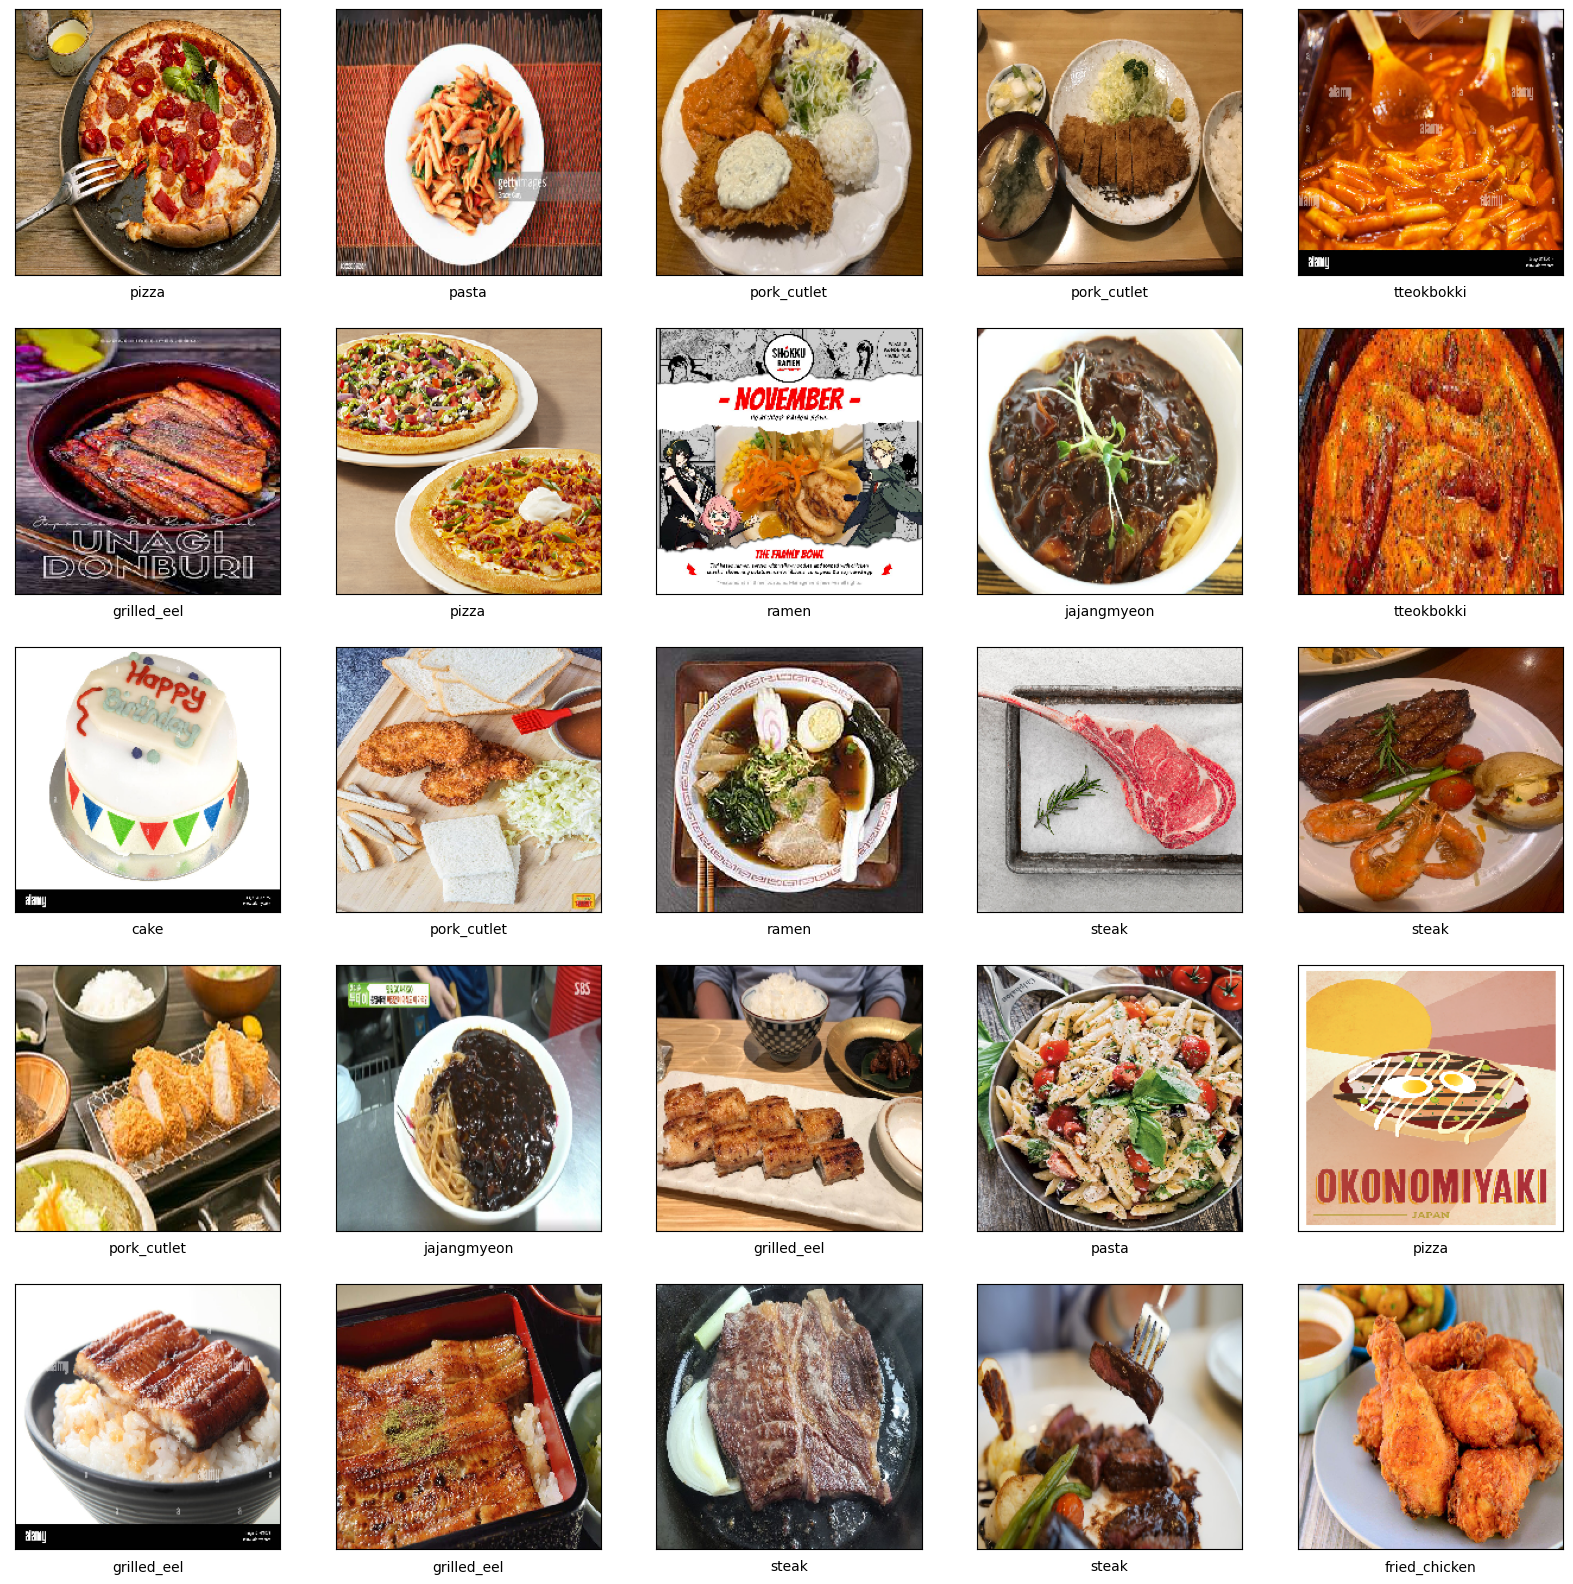

In [4]:
# 이미지 시각화

plt.figure(figsize=(20, 20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(os.path.join(label, path_img))

    img = image.load_img(path_img, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


In [5]:
cd ..

c:\Users\AI06\Desktop\DL


In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'])  # 라벨 비율 대로 데이터 분리
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)


In [7]:
def cls(x): return os.path.join(
    'train', '_'.join(x.split('_')[1:-1]) + '\\' + x)


train['image'] = train['image'].map(lambda x: cls(x))
train.head(10)

valid['image'] = valid['image'].map(lambda x: cls(x))
valid.head(10)


image         label
0               train\pasta\google_pasta_625.jpg         pasta
1                train\steak\naver_steak_178.jpg         steak
2               train\pizza\google_pizza_290.jpg         pizza
3  train\janchi_guksu\naver_janchi_guksu_404.jpg  janchi_guksu
4      train\tteokbokki\naver_tteokbokki_253.jpg    tteokbokki
5    train\jajangmyeon\naver_jajangmyeon_416.jpg   jajangmyeon
6                train\ramen\naver_ramen_106.jpg         ramen
7                 train\cake\google_cake_229.jpg          cake
8    train\grilled_eel\naver_grilled_eel_249.jpg   grilled_eel
9                 train\cake\google_cake_555.jpg          cake

In [8]:
# 데이터 증강 => 배치사이즈

height, width, channel = (224, 224, 3)
batch_size = 64
labels = train_df.label.unique().tolist()


# 증강옵션 제거 
# EfficientNet은 rescale하면 안됨 
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_dataframe(train,
                                                    x_col='image',
                                                    y_col='label',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


valid_generator = datagen.flow_from_dataframe(valid,
                                                    x_col='image',
                                                    y_col='label',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


Found 9056 validated image filenames belonging to 12 classes.
Found 2265 validated image filenames belonging to 12 classes.


In [9]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [10]:
# Adds new top to base model
def build_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Output layer
    outputs = Dense(len(labels), activation='softmax')(x)

    return Model(inputs=base.input, outputs=outputs)


# Sets up model for transfer learning
def setup_model(model, base):
    # 가중치 동결
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(0.001),
        metrics=['accuracy']
    )


In [12]:
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB7(input_tensor=input_tensor, include_top=False, weights='imagenet')

model = build_top(base_model)
setup_model(model, base_model)


In [59]:
# 조기멈춤
stop = EarlyStopping(patience=10)

# 자동 저장
checkpoint = ModelCheckpoint("EfficientNet_best/model_weights", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1, save_best_only=True)

callbacks = [stop, checkpoint]

In [60]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=25, callbacks=callbacks)

Epoch 1/25
  1/142 [..............................] - ETA: 31:06 - loss: 5.5921 - accuracy: 0.0625

c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


142/142 [==============================] - ETA: 0s - loss: 2.0922 - accuracy: 0.3815
Epoch 1: val_accuracy improved from -inf to 0.73819, saving model to EfficientNet_best\model_weights
142/142 [==============================] - 114s 714ms/step - loss: 2.0922 - accuracy: 0.3815 - val_loss: 1.3804 - val_accuracy: 0.7382
Epoch 2/25
142/142 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.6119
Epoch 2: val_accuracy improved from 0.73819 to 0.79470, saving model to EfficientNet_best\model_weights
142/142 [==============================] - 99s 698ms/step - loss: 1.2275 - accuracy: 0.6119 - val_loss: 0.8234 - val_accuracy: 0.7947
Epoch 3/25
142/142 [==============================] - ETA: 0s - loss: 1.0193 - accuracy: 0.6889
Epoch 3: val_accuracy improved from 0.79470 to 0.83753, saving model to EfficientNet_best\model_weights
142/142 [==============================] - 102s 719ms/step - loss: 1.0193 - accuracy: 0.6889 - val_loss: 0.6390 - val_accuracy: 0.8375
Epoch 4/25

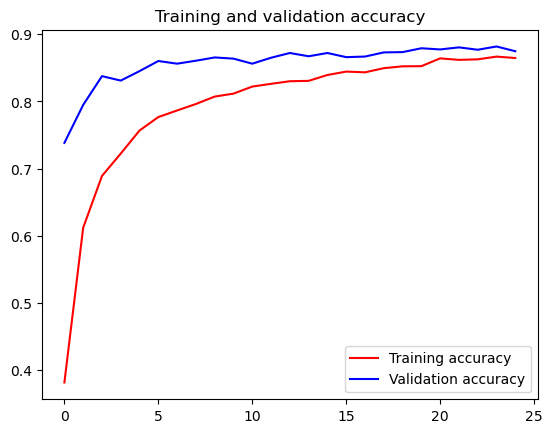

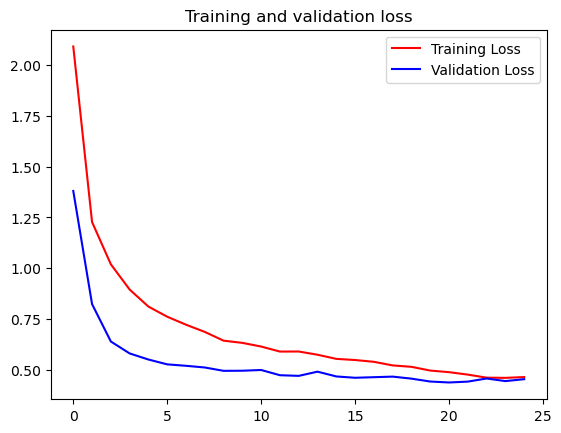

In [61]:
# 학습 곡선 확인

def plot_history():
    plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(history.history['loss'], 'r', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history()


In [62]:
# 재학습 위한 증강 

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             zoom_range=[0.8, 1],
                             horizontal_flip=True,
                             fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(train,
                                              x_col='image',
                                              y_col='label',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              target_size=(height, width))


valid_generator = datagen.flow_from_dataframe(valid,
                                              x_col='image',
                                              y_col='label',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              target_size=(height, width))


Found 9056 validated image filenames belonging to 12 classes.
Found 2265 validated image filenames belonging to 12 classes.


In [63]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(0.0003), loss="categorical_crossentropy", metrics=["accuracy"])


unfreeze_model(model)


In [ ]:
mo

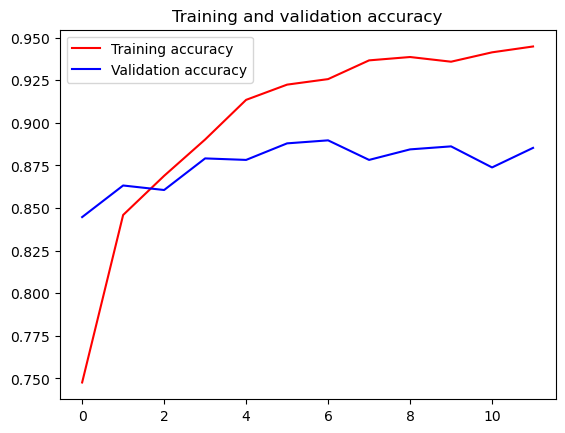

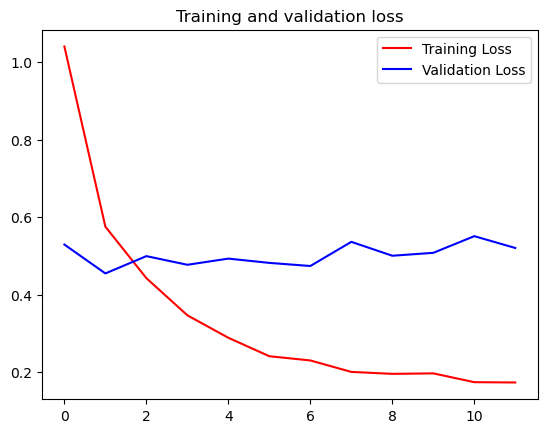

In [31]:
plot_history()

### test set으로 예측 

In [24]:
test_df = pd.read_csv("submission.csv")
test_df.head(5)


batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

path = os.path.join('test')

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)

cnt = 0


(2766, 224, 224, 3)


In [25]:
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(path, path_img),
                         target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor, dtype="float32")

    img_tensor /= 255

    img_tensor = np.expand_dims(img_tensor, axis=0)

    test_image[i] = img_tensor

    if (i % 100 == 0):
        print(str(i) + " 완료")  # 진행 상황 확인용


0 완료
100 완료


c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200 완료
300 완료
400 완료
500 완료
600 완료
700 완료
800 완료
900 완료
1000 완료
1100 완료
1200 완료
1300 완료
1400 완료
1500 완료
1600 완료
1700 완료
1800 완료
1900 완료
2000 완료
2100 완료
2200 완료
2300 완료
2400 완료
2500 완료
2600 완료
2700 완료


In [26]:

pred2label = {}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x

In [28]:
predictions = model.predict(test_image)


test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]

print(test_df)

test_df.to_csv('/submissions/tuned_efficientNet.csv', index=False)


87/87 [==============================] - 6s 72ms/step
              image          label
0     test_1553.jpg    jajangmyeon
1     test_2202.jpg          ramen
2     test_1556.jpg    pork_cutlet
3      test_660.jpg          pizza
4      test_677.jpg          ramen
...             ...            ...
2761  test_2189.jpg          pasta
2762   test_223.jpg  fried_chicken
2763   test_303.jpg   janchi_guksu
2764  test_1681.jpg   janchi_guksu
2765   test_777.jpg           cake

[2766 rows x 2 columns]
